# DataSet class walkthrough

In this notebook we are going to go through the mighty `DataSet` class, and get an overview of the most of it's methods and properties. In this case, the more you know, the more you can achieve.

## Note on DataSet object creation

Users are expected obtain `DataSet` objects in the following ways:

* run a `Measurement` and get a `DataSet` via a `DataSaver` after exiting the measurement context, as shown here:

```python
...
meas = Measurement(...)
...
with meas.run() as datasaver:
    ...
dataset = datasaver.dataset  # <- this one
...
```

* load a `DataSet` using one of the `load_*` functions from `qcodes.dataset.data_set` module, for example, `load_by_run_spec`:

```python
dataset = load_by_run_spec(
    experiment_name='pinchoff',
    sample_name='SDH-X-13c',
    captured_run_id=12
)
```

Users are NOT expected to instantiate `DataSet` objects via its constructor, neither they are expected to use the `new_data_set` function.

## Preparation: a DataSet from a dummy Measurement

In order to obtain a `DataSet` object, we are going to run a `Measurement` storing some dummy data (see `Dataset Context Manager` notebook for more details).

In [1]:
import tempfile
import os

import numpy as np

import qcodes
from qcodes import initialise_or_create_database_at, \
    load_or_create_experiment, Measurement, Parameter, \
    Station
from qcodes.dataset.plotting import plot_dataset

In [2]:
db_path = os.path.join(tempfile.gettempdir(),
                       'data_access_example.db')
initialise_or_create_database_at(db_path)

experiment = load_or_create_experiment(
    experiment_name='greco',
    sample_name='draco')

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 421.58it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 157.50it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 207.52it/s]


In [3]:
# This parameter is created in order to
# justify creation of a `Station` object,
# which, in turn, is needed to remind the
# reader about the importance of adding 
# all instruments to the station.
fs = Parameter(name='force_side', label='Side of the Force',
               initial_value='dark',
               set_cmd=None, get_cmd=None)

In [4]:
station = Station()
station.add_component(fs)

'force_side'

In [5]:
x = Parameter(name='x', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
t = Parameter(name='t', label='Time', unit='s',
              set_cmd=None, get_cmd=None)
y = Parameter(name='y', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
y2 = Parameter(name='y2', label='Current', unit='A',
               set_cmd=None, get_cmd=None)

In [6]:
meas = Measurement(exp=experiment, station=station)

meas.name = 'first_run'

meas.register_parameter(x)
meas.register_parameter(t)
meas.register_parameter(y, setpoints=(x, t))
meas.register_parameter(y2, setpoints=(x, t))

x_vals = np.linspace(-4, 5, 50)
t_vals = np.linspace(-500, 1500, 25)

with meas.run() as datasaver:
    for xv in x_vals:
        for tv in t_vals:
            yv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            y2v = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv + 0.5*np.pi) - 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (y, yv), (y2, y2v))

dataset = datasaver.dataset

Starting experimental run with id: 1


For the sake of demonstating what kind of data we've produced, let's use `plot_dataset` to make some default plots of the data.

([<matplotlib.axes._subplots.AxesSubplot at 0x1217c8f50>,
  <matplotlib.colorbar.Colorbar at 0x121841790>])

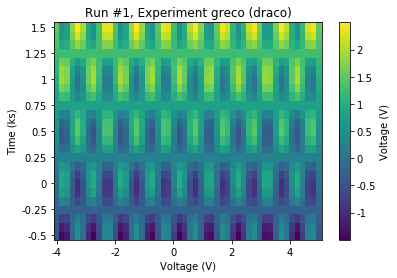

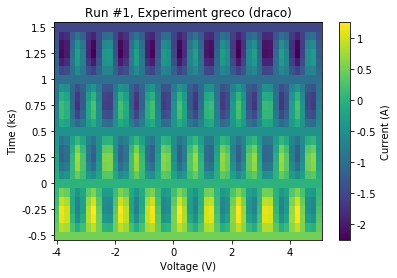

In [7]:
plot_dataset(dataset)

## Note on immutability of DataSet

Users are NOT expected to use `DataSet`s methods that modify its content, for example, `add_result`. Only `Measurement` and `DataSaver` objects use those methods. This is due to the phylosophy of the `DataSet` - once created within a `Measurement` context, it should not change so that the user don't accidentally modify/remove the important measured data. In the future versions of QCoDeS the design of the `DataSet` object will be improved to make the described phylosophy clear.

## DataSet indentity

Before we dive into what's in the `DataSet`, let's briefly note how a `DataSet` is identified.

Globally, "in this universe", a dataset is identified by a globally unique identifier:

In [8]:
dataset.guid

'aaaaaaaa-0000-0000-0000-016d21e26f2b'

`guid` is generated when a dataset is created, and is globally unique.

Due to the nature of the `guid` and its size, it is very user-friendly. For example, it is convenient use it as a reference in a conversation betweenusers. However, the `guid` is crutial for use in automated/computer systems, for example, when moving a dataset from one database file to a different one.

Within a given single database file (!) a dataset can be identified by its `run_id`, an integer index:

In [9]:
dataset.run_id

1

`run_id` gets assigned to a dataset upon its creation, and is unique only within that database file.

**Note** that `run_id` is NOT unique outside of a given database file. For example, if we extract a dataset with `run_id` `1` into another database file, the chances are high that the `run_id` of this dataset in that other database file will be different (for example, if that other database file already contains 3 datasets, then the `run_id` of the extracted dataset will be `4`).

Unlike `guid`, `run_id` is a convenient way to refer to a dataset, but *only within the scope of a single given database file*. In order to allow users to still use this convenient integer for referring to a dataset, the `run_id` that got assigned to a dataset upon its creation is also captured in the `captured_run_id`:

In [10]:
dataset.captured_run_id

1

`captured_run_id` gets assigned to a dataset upon its creation, but unlike `run_id` does not change when the dataset is extracted to another database file.

Every dataset contains the name of the experiment, and the name of the sample - those come from the `Experiment` object that was passed to the `Measurement` object with which the dataset has been created.

So here is the experiment name that has been used above:

In [11]:
dataset.exp_name

'greco'

And here is the sample name that has been used above:

In [12]:
dataset.sample_name

'draco'

Both experiment name and sample name are great means for identifying a dataset, especially when coupled with the `captured_run_id`.

Last but not least, a dataset may have a `name`. This name gets assigned to the dataset upon its creation, and is taken from the `name` attribute of the `Measurement` object that was used to create the dataset. For example, above the `name` of the `Measurement` was set, hence the produced `DataSet` also has this name:

In [13]:
dataset.name

'first_run'

If the `name` of the `Measurement` is not explicitly defined, the created dataset gets a default name.

### Note on experiments

Conceptually experiments are meant to group datasets under the same experiment name and sample name. This is why every dataset also contains the following `Experiment`-related identifications.

Experiments have integer ids within a database file. A dataset knows about the id of the experiment it belongs to via `exp_id` property:

In [14]:
dataset.exp_id

1

Because an `Experiment` is a group of datasets, every dataset also has a `counter` within an `Experiment`:

In [15]:
dataset.counter

1

So as `run_id`, the `counter` is unique only within an experiment within a single given database file. Hence, a `captured_counter` exists that is equal to the value of the `counter` that gets assigned to a dataset upon its creation:

In [16]:
dataset.captured_counter

1

For example, when a dataset gets extracted to a different database file, its `counter` within an experiment will likely change, while `captured_counter` will remain (poissibly resulting in more than one dataset within the same experiment having equal `captured_counter`s).

### Note on DataSet states

The `DataSet` object publicly exposes properties which give information about its state. However, users are expected to always get `DataSet` objects in their "final", last, unmodifiable state. This means that the "state" properties of the dataset will have the following values:

In [17]:
dataset.completed

True

In [18]:
dataset.started

True

In [19]:
dataset.running

False

In [20]:
dataset.pristine

False

## DataSet info

In this section we are going to look at different minor pieces of information about the dataset.

### Database file

Dataset is obviously aware of which database file it is contained in:

In [21]:
dataset.path_to_db

'/var/folders/3c/1hn5sc913p7dr8b07jgqqwtm0000gn/T/data_access_example.db'

### Timestamps

A dataset has  

In [22]:
dataset.run_timestamp()

'2019-09-11 21:52:30'

In [23]:
dataset.run_timestamp_raw

1568231550.7727659

In [24]:
dataset.completed_timestamp()

'2019-09-11 21:52:30'

In [25]:
dataset.completed_timestamp_raw

1568231550.88348

In [26]:
dataset.snapshot

{'station': {'instruments': {},
  'parameters': {'force_side': {'value': 'dark',
    'ts': '2019-09-11 21:52:30',
    'raw_value': 'dark',
    '__class__': 'qcodes.instrument.parameter.Parameter',
    'full_name': 'force_side',
    'name': 'force_side',
    'unit': '',
    'inter_delay': 0,
    'label': 'Side of the Force',
    'post_delay': 0}},
  'components': {},
  'default_measurement': []}}

In [27]:
dataset.snapshot_raw

'{"station": {"instruments": {}, "parameters": {"force_side": {"value": "dark", "ts": "2019-09-11 21:52:30", "raw_value": "dark", "__class__": "qcodes.instrument.parameter.Parameter", "full_name": "force_side", "name": "force_side", "unit": "", "inter_delay": 0, "label": "Side of the Force", "post_delay": 0}}, "components": {}, "default_measurement": []}}'

In [28]:
dataset.parent_dataset_links

[]

In [29]:
dataset.metadata

{}

In [30]:
dataset.get_metadata('name')

'first_run'

## Parameters in the DataSet

In this section we are getting information about the parameters stored in the given `DataSet`.

In [31]:
dataset.number_of_results

2500

In [32]:
dataset.parameters

'x,t,y,y2'

In [33]:
dataset.paramspecs

{'x': ParamSpec('x', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=[]),
 't': ParamSpec('t', 'numeric', 'Time', 's', inferred_from=[], depends_on=[]),
 'y': ParamSpec('y', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=['x', 't']),
 'y2': ParamSpec('y2', 'numeric', 'Current', 'A', inferred_from=[], depends_on=['x', 't'])}

In [34]:
dataset.get_parameters()

[ParamSpec('x', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=[]),
 ParamSpec('t', 'numeric', 'Time', 's', inferred_from=[], depends_on=[]),
 ParamSpec('y', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=['x', 't']),
 ParamSpec('y2', 'numeric', 'Current', 'A', inferred_from=[], depends_on=['x', 't'])]

In [35]:
dataset.dependent_parameters

(ParamSpecBase('y', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'))

In [36]:
dataset.description

RunDescriber(InterDependencies_(dependencies={ParamSpecBase('y', 'numeric', 'Voltage', 'V'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's')), ParamSpecBase('y2', 'numeric', 'Current', 'A'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's'))}, inferences={}, standalones=frozenset()))

## Getting data from DataSet

??

In [37]:
dataset.get_data
dataset.get_values
dataset.get_setpoints

<bound method DataSet.get_setpoints of first_run #1@/var/folders/3c/1hn5sc913p7dr8b07jgqqwtm0000gn/T/data_access_example.db
------------------------------------------------------------------------------------
x - numeric
t - numeric
y - numeric
y2 - numeric>

In [38]:
dataset.get_parameter_data

<bound method DataSet.get_parameter_data of first_run #1@/var/folders/3c/1hn5sc913p7dr8b07jgqqwtm0000gn/T/data_access_example.db
------------------------------------------------------------------------------------
x - numeric
t - numeric
y - numeric
y2 - numeric>